# HW3

Christopher Csiszar

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import re
import matplotlib.pyplot as plt
from itertools import chain
import math
import random

import torch
import torch.nn
import torch.nn.functional as F
import torch.utils.data as tData
from torchvision import models
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
torch.cuda.empty_cache()

In [3]:
PATH = '/home/chris/catchup/DL/HW3/data'

def load_train(path):
    train_set = pd.read_csv(os.path.join(path, 'train_labels.csv'))
    train_label = np.array(train_set['invasive'])
    train_files = []
    for i in range(len(train_set)):
        train_files.append(os.path.join(path, 'train', str(int(train_set.iloc[i, 0])) +'.jpg'))
    train_set['name'] = train_files
    return train_files, train_set, train_label

train_files, train_set, train_label = load_train(PATH)

train_set.head()

,name,invasive
0,/home/chris/catchup/DL/HW3/data/train/1.jpg,0
1,/home/chris/catchup/DL/HW3/data/train/2.jpg,0
2,/home/chris/catchup/DL/HW3/data/train/3.jpg,1
3,/home/chris/catchup/DL/HW3/data/train/4.jpg,0
4,/home/chris/catchup/DL/HW3/data/train/5.jpg,1


In [4]:
def load_test(path):
    test_set = pd.DataFrame(columns=['name', 'invasive'])
    test_files = []
    idx = []
    test_path = os.path.join(path, 'test')
    for f in os.listdir(test_path):
        if f.endswith('.jpg'):
            idx.append(int(re.findall('[0-9]+', f)[0]))
            test_files.append(os.path.join(test_path, f))
    test_set['name'] = test_files
    test_set['idx'] = idx
    test_set['invasive'] = 0.5
    return test_files, test_set.sort_values(by='idx').drop('idx', axis=1).reset_index(drop=True)

test_files, test_set = load_test(PATH)

test_set.head()

,name,invasive
0,/home/chris/catchup/DL/HW3/data/test/1.jpg,0.5
1,/home/chris/catchup/DL/HW3/data/test/2.jpg,0.5
2,/home/chris/catchup/DL/HW3/data/test/3.jpg,0.5
3,/home/chris/catchup/DL/HW3/data/test/4.jpg,0.5
4,/home/chris/catchup/DL/HW3/data/test/5.jpg,0.5


In [5]:
# modified from fast.ai

def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, reflect=True, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if reflect:
        return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)
    return cv2.warpAffine(im,M,(c,r), borderMode=cv2.BORDER_DEFAULT, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [6]:
class InvasiveSpeciesDataSet(tData.Dataset):
    def __init__(self, df, transforms=False, sz=224):
        super(InvasiveSpeciesDataSet, self).__init__()
        self.df = df
        self.transforms = transforms
        self.sz = sz
        self.sz2 = int(sz*1.05)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        path = self.df.loc[idx, 'name']
        x = cv2.cvtColor(cv2.imread(str(path)).astype(np.float32), cv2.COLOR_BGR2RGB)/255
        x = center_crop(x)
        if self.transforms:
            x = cv2.resize(x, (self.sz2, self.sz2))
            x = random_crop(x, self.sz, self.sz)
            rdeg = (np.random.random()-50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5:
                x = np.fliplr(x).copy()
        else:
            x = cv2.resize(x, (self.sz, self.sz))
        #x = normalize(x)
        return np.rollaxis(x, 2), self.df.loc[idx, 'invasive']

In [7]:
train_df, val_df = train_test_split(train_set, train_size = 0.8, shuffle=True, random_state=42)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
print(sum(train_df['invasive']/train_df.shape[0]), sum(val_df['invasive']/val_df.shape[0]))

0.6290849673202613 0.6383442265795197


/home/chris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
train_ds = InvasiveSpeciesDataSet(train_df, transforms=True)
train_dl = tData.DataLoader(train_ds, batch_size=8, shuffle=True)
val_ds = InvasiveSpeciesDataSet(val_df)
val_dl = tData.DataLoader(val_ds, batch_size=4)

In [9]:
len(train_ds), len(val_ds)

(1836, 459)

In [10]:
X, y = next(iter(train_dl))
X.shape, y.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

In [11]:
X, y = next(iter(val_dl))
X.shape, y.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

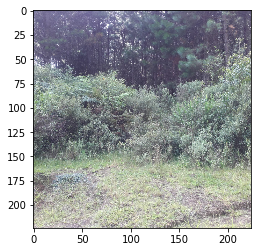

In [12]:
plt.imshow(np.rollaxis(X[2].numpy(), 0, 3))

# Model

Using the first layers of inception v3

In [13]:
inception3 = models.inception_v3(pretrained=True, transform_input=True)
inception3.aux_logits = False
layers = list(inception3.children())
print(len(layers))
layers[-1:]

18


[Linear(in_features=2048, out_features=1000, bias=True)]

In [14]:
class InvasiveCNN(torch.nn.Module):
    def __init__(self, inception):
        super(InvasiveCNN, self).__init__()
        
        inception.aux_logits = False
        
        # Freeze inception params
        for param in inception.parameters():
            param.requires_grad = False
            
        # Convolutional layers of inception3
        # Exclude aux_logits layer, and last (fully-connected) layer
        include_layers = np.array([True if idx != 13 and idx != 17 else False for idx in range(18)])
        layers = np.array(list(inception.children()))[include_layers]
        self.bn1 = torch.nn.BatchNorm2d(3)
        self.top_model = torch.nn.Sequential(*layers).cuda()
        self.pool = torch.nn.AdaptiveAvgPool2d(1)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(2048, 512)
        self.bn2 = torch.nn.BatchNorm1d(512)
        self.fc2 = torch.nn.Linear(512, 1)
        
    def forward(self, x):
        x = self.bn1(x)
        x = F.relu(self.top_model(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [15]:
model_test = InvasiveCNN(inception3).cuda()
y_hat = model_test(X.cuda().float())
y_hat

tensor([[ 0.3891],
        [-0.3129],
        [-0.1003],
        [-0.1122]], device='cuda:0')

# LR Finder

In [16]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [17]:
def lr_finder(model_lrfind, data_loader, epochs=5, lr_pow_low=-5, lr_pow_high=-2, wd=0.0):
    model_lrfind.train()
    steps = epochs*len(data_loader)
    losses = np.zeros(steps)
    lr = np.logspace(lr_pow_low, lr_pow_high, num=steps)
    
    batch = 0
    for epoch in range(epochs):
         for X, y in data_loader:
            cur_lr = lr[batch]
            optimizer = get_optimizer(model_lrfind, cur_lr, wd)
            X = X.float().cuda()
            y = y.float().cuda()
            y_hat = model_lrfind(X).view(-1)
            loss = F.binary_cross_entropy_with_logits(y_hat, y)
            losses[batch] = loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (batch % 10 == 0) and (batch != 0):
                print(batch, cur_lr, np.mean(losses[batch-10:batch]))
            batch += 1
            
    plt.plot(lr, losses)
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.show()
    return lr, losses

10 1.061963672152304e-05 0.6652738511562347
20 1.1277668409712038e-05 0.6731463491916656
30 1.1976474157693832e-05 0.683372312784195
40 1.2718580475941688e-05 0.6868093550205231
50 1.3506670426795633e-05 0.7001782774925231
60 1.4343593324990818e-05 0.7052826464176178
70 1.5232375039266492e-05 0.7021298825740814
80 1.617622893230054e-05 0.6612317204475403
90 1.7178567478522192e-05 0.7016440868377686
100 1.824301460180757e-05 0.6794313430786133
110 1.9373418777663672e-05 0.7216264069080353
120 2.057386694727207e-05 0.6784588813781738
130 2.184869929369796e-05 0.6810584366321564
140 2.320252493368689e-05 0.6616915464401245
150 2.464023858178352e-05 0.6724684655666351
160 2.616703824701971e-05 0.6722105920314789
170 2.7788444026154782e-05 0.6683860003948212
180 2.9510318061414087e-05 0.6481201827526093
190 3.1338885734881704e-05 0.6645734548568726
200 3.328075817617643e-05 0.6730087161064148
210 3.5342956164785134e-05 0.6390778005123139
220 3.753293551347306e-05 0.6669003069400787
230 3.98

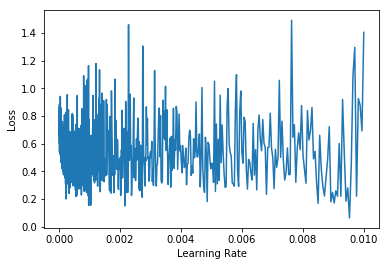

In [18]:
model_lr = InvasiveCNN(inception3).cuda()
lrs, losses = lr_finder(model_lr, train_dl)

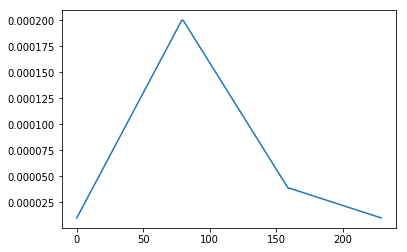

In [19]:
def get_triangular_lr(lr_low, lr_high, mini_batches):
    iterations = mini_batches
    lr_mid = lr_high/7 + lr_low
    up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
    down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
    floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.305)))
    return np.hstack([up, down, floor])

lrs = get_triangular_lr(1e-5, 1e-4*2, len(train_dl))
plt.plot(lrs)

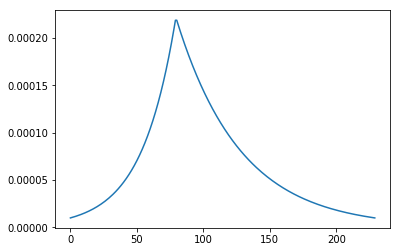

In [20]:
def get_log_triangular_lr(lr_pow_low, lr_pow_high, mini_batches):
    iterations = mini_batches
    up = np.logspace(lr_pow_low, lr_pow_high, int(round(iterations*0.35)))
    down = np.logspace(lr_pow_high, lr_pow_low, int(round(iterations*0.65)))
    return np.hstack([up, down])

lrs = get_log_triangular_lr(-5, -3.66, len(train_dl))
plt.plot(lrs)

In [21]:
len(train_dl), len(lrs)

(230, 230)

# Training

In [22]:
def val_metrics(m):
    m.eval()
    val_loss = 0
    val_correct = 0
    total_examples = 0
    for (X,y) in val_dl:
        X = X.float().cuda()
        y = y.float().cuda()
        y_hat = m(X).view(-1)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        val_loss += loss.item()
        y_pred = y_hat > 0.0
        correct = (y_pred.float() == y).float().sum()
        val_correct += correct
        total_examples += y_pred.shape[0]
    val_loss /= len(val_dl)
    val_accuracy = val_correct / total_examples
    print("\tval loss %.3f and accuracy %.3f" % (val_loss, val_accuracy))

In [23]:
model = InvasiveCNN(inception3).cuda()
val_metrics(model)

	val loss 0.691 and accuracy 0.636


In [24]:
def train_model(m, data_loader, epochs=10, start_epoch=0, lr_pow_low=-5, lr_pow_high=-3.66, wd=0.0):
    lr = get_log_triangular_lr(lr_pow_low, lr_pow_high, len(data_loader))
    for i in range(epochs):
        m.train()
        train_loss = 0
        train_correct = 0
        total_examples = 0
        for batch, (cur_lr, (X, y)) in enumerate(zip(lr, data_loader)):
            optimizer = get_optimizer(m, cur_lr, wd)
            X = X.float().cuda()
            y = y.float().cuda()
            y_hat = m(X).view(-1)
            loss = F.binary_cross_entropy_with_logits(y_hat, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_pred = y_hat > 0.0
            train_correct += (y_pred.float() == y).float().sum()
            total_examples += y_pred.shape[0]
        print('Epoch {}'.format(i+start_epoch))        
        train_loss /= len(data_loader)
        train_accuracy = train_correct / total_examples
        print("\ttrain loss %.3f and accuracy %.3f" % (train_loss, train_accuracy))
        val_metrics(m)
    save_model(m, os.path.join(PATH, 'InvasiveCNN.pth'))

In [25]:
model = InvasiveCNN(inception3).cuda()

In [26]:
train_model(model, train_dl, epochs=5)

Epoch 0
	train loss 0.632 and accuracy 0.638
	val loss 0.618 and accuracy 0.647
Epoch 1
	train loss 0.535 and accuracy 0.746
	val loss 0.567 and accuracy 0.712
Epoch 2
	train loss 0.514 and accuracy 0.757
	val loss 0.573 and accuracy 0.702
Epoch 3
	train loss 0.485 and accuracy 0.769
	val loss 0.498 and accuracy 0.763
Epoch 4
	train loss 0.468 and accuracy 0.774
	val loss 0.466 and accuracy 0.793


In [28]:
save_model(model, os.path.join(PATH, 'inceptionv3'))

In [29]:
test_ds = InvasiveSpeciesDataSet(test_set)
test_dl = tData.DataLoader(test_ds)

In [30]:
def test_prediction(m, test_df):
    test_df_out = test_df.copy()
    m.eval()
    test_preds = np.zeros((test_set.shape[0],1))
    for i, (X,y) in enumerate(test_dl):
        X = X.float().cuda()
        y_hat = m(X).view(-1)
        y_pred = F.sigmoid(y_hat)
        test_preds[i] = y_pred.cpu().detach().numpy()
    test_df_out['invasive'] = test_preds
    return test_df_out

In [31]:
test_preds = test_prediction(model, test_set)

In [32]:
test_preds.head()

,name,invasive
0,/home/chris/catchup/DL/HW3/data/test/1.jpg,0.474966
1,/home/chris/catchup/DL/HW3/data/test/2.jpg,0.306505
2,/home/chris/catchup/DL/HW3/data/test/3.jpg,0.089211
3,/home/chris/catchup/DL/HW3/data/test/4.jpg,0.128106
4,/home/chris/catchup/DL/HW3/data/test/5.jpg,0.963821


In [33]:
test_preds['idx'] = test_preds['name'].apply(lambda f: int(re.findall('[0-9]+', f)[1]))

In [34]:
test_preds.drop('name', axis=1, inplace=True)
test_preds.head()

,invasive,idx
0,0.474966,1
1,0.306505,2
2,0.089211,3
3,0.128106,4
4,0.963821,5


In [35]:
test_preds.rename(columns={'idx':'name'}, inplace=True)
test_preds.head()

,invasive,name
0,0.474966,1
1,0.306505,2
2,0.089211,3
3,0.128106,4
4,0.963821,5


In [36]:
test_preds[['name', 'invasive']].to_csv('submission.csv', index=False)

In [37]:
! pwd

/home/chris/catchup/DL/HW3
